In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
project_path = "/content/drive/MyDrive/Brain-Tumor-Detection"
os.chdir(project_path)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [11]:
# Dataset
import zipfile

z = zipfile.ZipFile('dataset.zip')

z.extractall()

In [12]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [13]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [14]:
# EDA(Exploratory Data Analysis)

In [15]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


In [16]:
# Plot

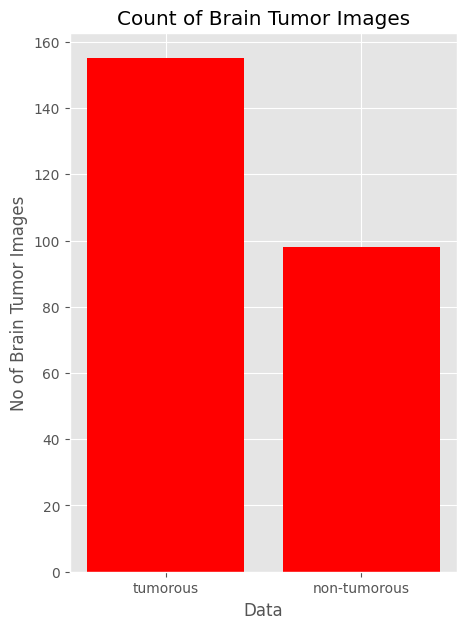

In [17]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [18]:
# Data Augmentation
# 155(61%), 98(39%)
# imbalance

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [20]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [21]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [22]:
import time
start_time = time.time()



yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

import os
os.makedirs(augmented_data_path + 'yes', exist_ok=True)
os.makedirs(augmented_data_path + 'no', exist_ok=True)

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:54.92351245880127


In [23]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [24]:
data_summary(augmented_data_path)

Number of sample: 2062
1085 Number of positive sample in percentage: 52.618816682832204%
977 Number of negative sample in percentage: 47.381183317167796%


In [25]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1085
977


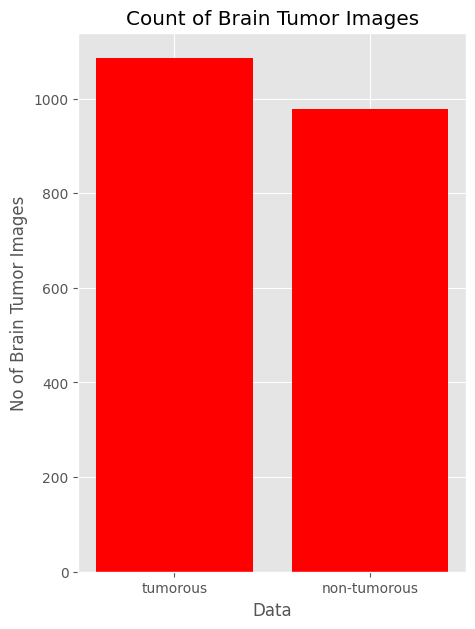

In [26]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [27]:
# Data Preprocessing

In [28]:
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [29]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


In [30]:
# import os

# img_path = '/content/augmented_data/yes/aug_Y_100_0_1019.jpg'
# if not os.path.exists(img_path):
#     print(f"File not found: {img_path}")
# else:
#     img = cv2.imread(img_path)
# crop_brain_tumor(img, True)

In [31]:
# img = cv2.imread('/content/augmented_data/no/aug_N_10_0_3000.jpg')
# crop_brain_tumor(img, True)

In [32]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [33]:
# image loading

In [34]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [35]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2062
X SHAPE is : (2062, 240, 240, 3)
y SHAPE is : (2062,)


In [39]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

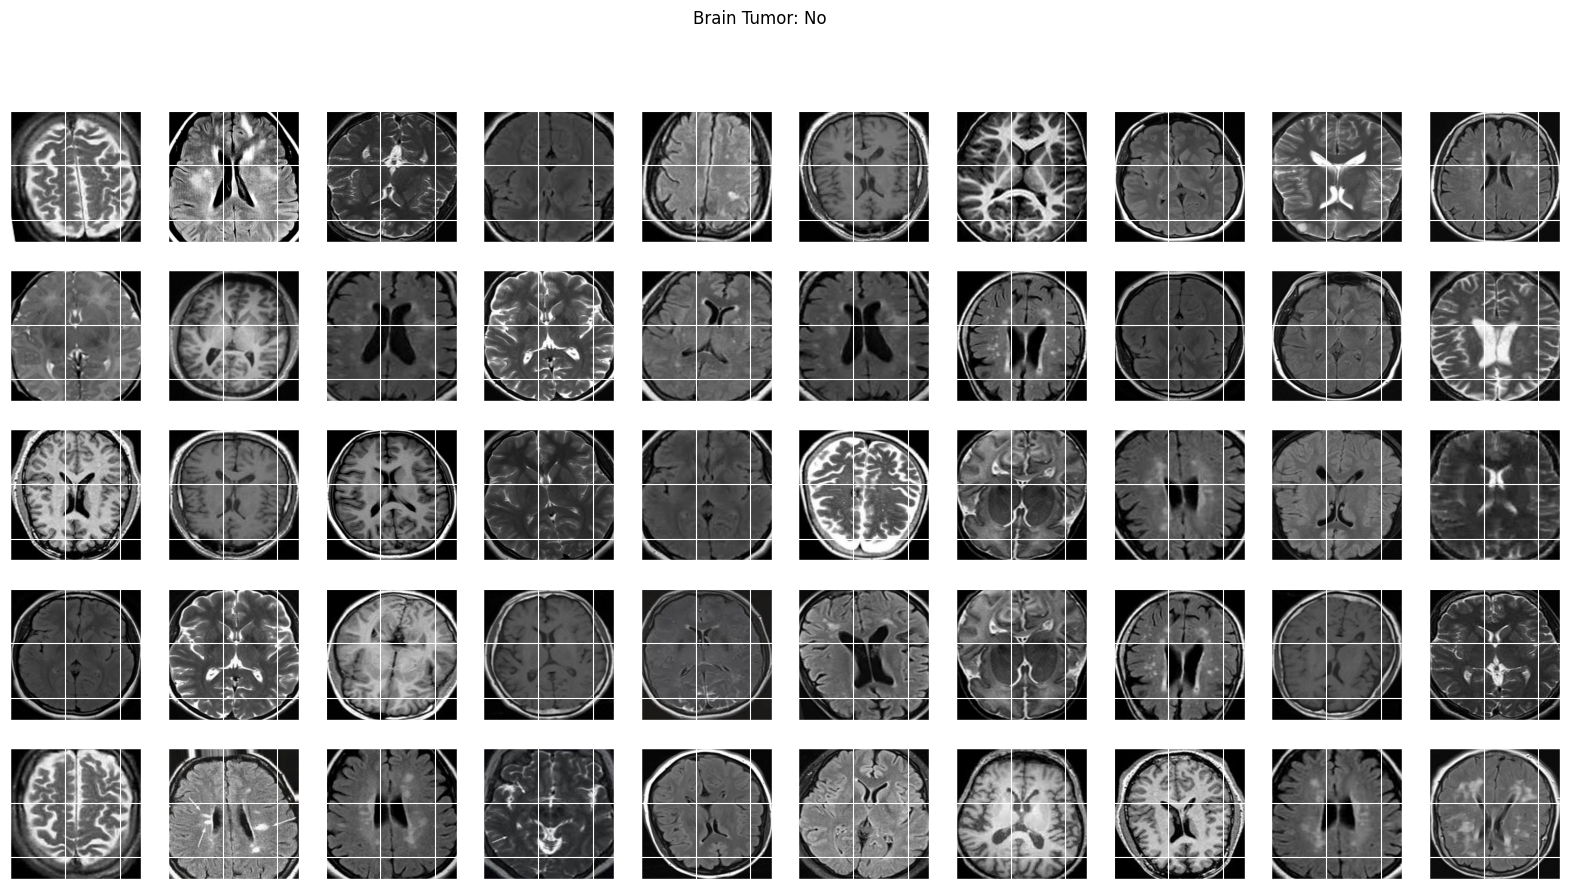

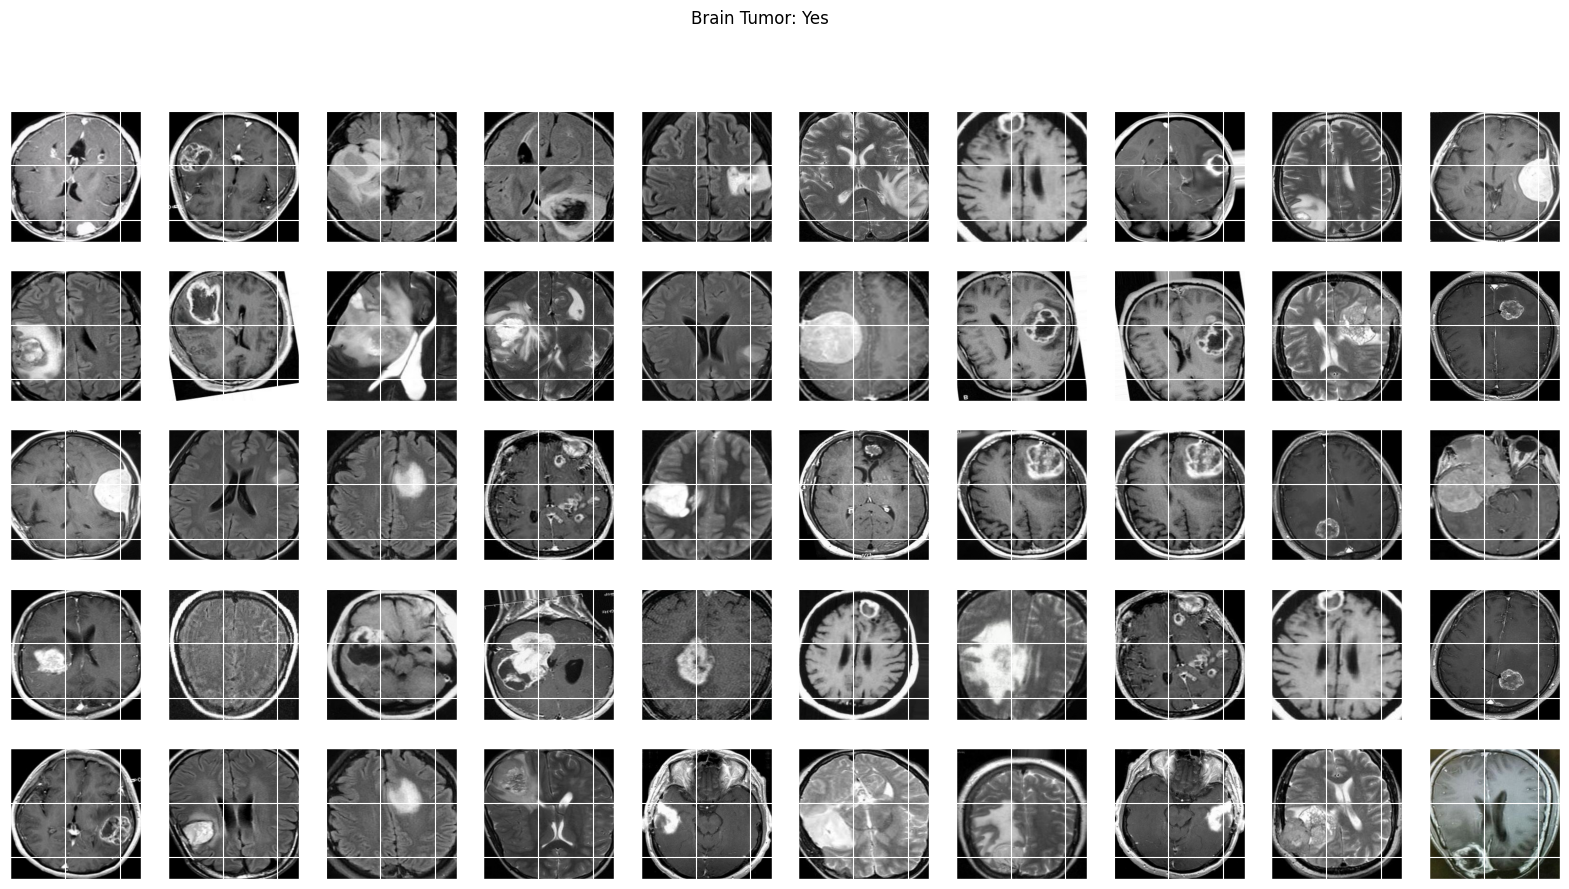

In [40]:
plot_sample_images(X,y)

In [41]:
# Data Spliting
# Train
# Test
# Validation

In [42]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [43]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [44]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [45]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [46]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [47]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [51]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [52]:
print(len(files))


1085


In [53]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [54]:
# 80% 10% 10%

In [55]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [57]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [58]:
print(len(files))


977


In [60]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833, 977):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [61]:
# Model Buliding

In [62]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [63]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 1445 images belonging to 2 classes.


In [64]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [65]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 306 images belonging to 2 classes.


In [66]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [67]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [68]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [69]:
# callback
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [70]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [71]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 15, callbacks=[es,cp,lrr], validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.4956 - loss: 0.7295
Epoch 1: val_loss improved from inf to 0.71226, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.4952 - loss: 0.7292 - val_accuracy: 0.5261 - val_loss: 0.7123 - learning_rate: 1.0000e-04
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5824 - loss: 0.7216
Epoch 2: val_loss improved from 0.71226 to 0.68633, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5791 - loss: 0.7215 - val_accuracy: 0.5359 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.5693 - loss: 0.6963
Epoch 3: val_loss did not improve from 0.68633
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5706 - loss: 0.6967 - val_accuracy: 0.5556 - val_loss: 0.7026 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5086 - loss: 0.7336
Epoch 4: val_loss improved from 0.68633 to 0.68576, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5130 - loss: 0.7303 - val_accuracy: 0.5425 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 5/15
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6097 - loss: 0.6817

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss improved from 0.68576 to 0.67325, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6117 - loss: 0.6828 - val_accuracy: 0.5784 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6151 - loss: 0.6483
Epoch 6: val_loss improved from 0.67325 to 0.67131, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6157 - loss: 0.6487 - val_accuracy: 0.5850 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.6217 - loss: 0.6512
Epoch 7: val_loss did not improve from 0.67131
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6201 - loss: 0.6518 - val_accuracy: 0.5588 - val_loss: 0.6715 - learning_rate: 1.0000e-04
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5963 - loss: 0.6955
Epoch 8: val_loss improved from 0.67131 to 0.66982, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


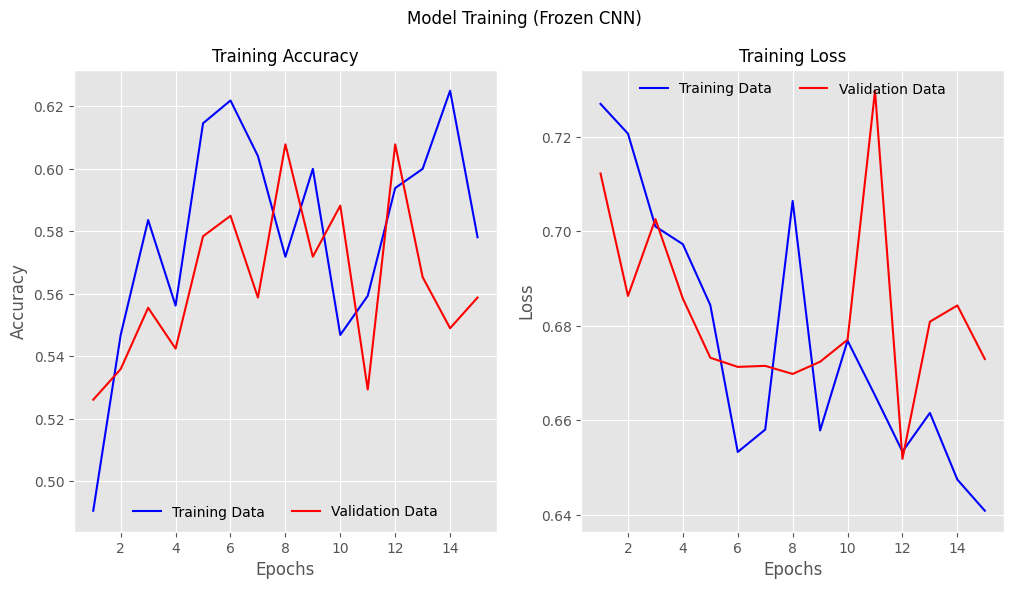

In [73]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [74]:
if not os.path.isdir('model_weights.h5'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [75]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 650ms/step - accuracy: 0.5812 - loss: 0.6640


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6704 - loss: 0.6083


In [76]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.666398286819458
Validation Acc: 0.5751634240150452
Testing Loss: 0.609736979007721
Testing Acc: 0.6774193644523621


In [77]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step   


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [78]:
# Increamental unfreezing and fine tuning

In [79]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [80]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [81]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [82]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 15, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_49']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6437 - loss: 0.6238
Epoch 1: val_loss did not improve from 0.65186
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6442 - loss: 0.6234 - val_accuracy: 0.5817 - val_loss: 0.6763 - learning_rate: 1.0000e-04
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6692 - loss: 0.6011
Epoch 2: val_loss did not improve from 0.65186
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6706 - loss: 0.6010 - val_accuracy: 0.5882 - val_loss: 0.6964 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5867 - loss: 0.6910
Epoch 3: val_loss improved from 0.65186 to 0.64724, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5885 - loss: 0.6876 - val_accuracy: 0.6438 - val_loss: 0.6472 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6357 - loss: 0.6485
Epoch 4: val_loss did not improve from 0.64724
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 996ms/step - accuracy: 0.6382 - loss: 0.6459 - val_accuracy: 0.5817 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 5/15
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.6370 - loss: 0.6579
Epoch 5: val_loss did not improve from 0.64724
10/10 ━━━━━━━━━

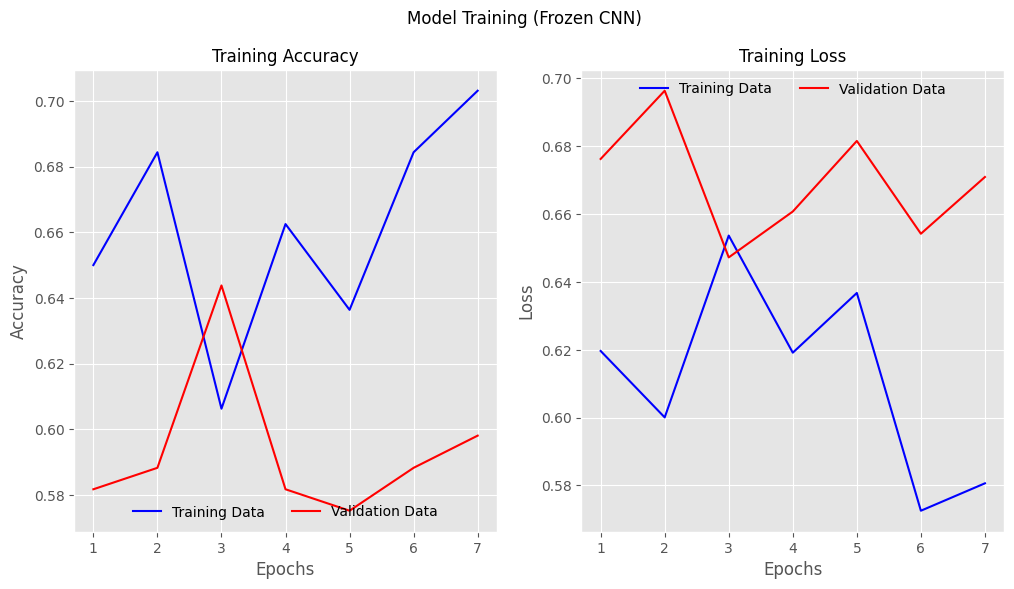

In [83]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, len(history_02.history['accuracy']) + 1))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [84]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [85]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 746ms/step - accuracy: 0.5884 - loss: 0.6688
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 621ms/step - accuracy: 0.6274 - loss: 0.6041


In [86]:
# Unfreezing the entire network

In [90]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Load VGG19 without top layers
base_model = VGG19(include_top=False, input_shape=(240, 240, 3))

# Optional: List all layer names
base_model_layer_names = [layer.name for layer in base_model.layers]

# Build custom top layers
x = base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Create model
model_03 = Model(inputs=base_model.inputs, outputs=output)

# Load pre-trained weights
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Create optimizer with learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile model
model_03.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [91]:
model_03.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 15, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_103']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.6319 - loss: 0.6180
Epoch 1: val_loss did not improve from 0.64724
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6347 - loss: 0.6166 - val_accuracy: 0.6144 - val_loss: 0.6695 - learning_rate: 1.0000e-04
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.6669 - loss: 0.6106
Epoch 2: val_loss improved from 0.64724 to 0.64666, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6688 - loss: 0.6096 - val_accuracy: 0.6013 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7450 - loss: 0.5698
Epoch 3: val_loss improved from 0.64666 to 0.62365, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - accuracy: 0.7436 - loss: 0.5688 - val_accuracy: 0.6046 - val_loss: 0.6236 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.6064 - loss: 0.6551
Epoch 4: val_loss improved from 0.62365 to 0.62301, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - accuracy: 0.6109 - loss: 0.6496 - val_accuracy: 0.6438 - val_loss: 0.6230 - learning_rate: 1.0000e-04
Epoch 5/15
 6/10 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.7397 - loss: 0.6035

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss improved from 0.62301 to 0.60858, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.7438 - loss: 0.5883 - val_accuracy: 0.6209 - val_loss: 0.6086 - learning_rate: 1.0000e-04
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.7737 - loss: 0.5111
Epoch 6: val_loss did not improve from 0.60858
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7741 - loss: 0.5118 - val_accuracy: 0.5817 - val_loss: 0.6726 - learning_rate: 1.0000e-04
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7948 - loss: 0.4980
Epoch 7: val_loss did not improve from 0.60858
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7927 - loss: 0.4980 - val_accuracy: 0.6275 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7432 - loss: 0.5247
Epoch 8: val_loss improved from 0.60858 to 0.60733, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.7438 - l

In [93]:
# model_03.load_weights("model_weights/vgg_unfrozen.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.7064 - loss: 0.5170
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - accuracy: 0.7252 - loss: 0.4973


In [94]:
# prompt: save this model "model_03" as .kersa on drive

model_03.save('/content/drive/MyDrive/model_03.keras')

In [101]:
# Step 1: Install required tools
!pip install streamlit pyngrok

# Step 2: Authenticate ngrok (replace YOUR_TOKEN)
!ngrok config add-authtoken YOUR_NGROK_AUTH_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [113]:
# Step 3: Run the Streamlit app
from pyngrok import ngrok

# Open a tunnel to localhost:8501 (Streamlit default port)
public_url = ngrok.connect("http://localhost:8501")
print("Streamlit app is live at:", public_url)

# Step 4: Launch the app
!streamlit run app.py --server.port 8501

Streamlit app is live at: NgrokTunnel: "https://6456-34-145-36-173.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.145.36.173:8501

2025-05-18 16:45:06.084051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747586706.107306   32490 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747586706.114370   32490 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 16:45:09.152806: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call 